### Постановка задачи
EDA - Exploratory Data Analysis

Проверить взаимосвязи между параметрами измерений, найти потенциальные особенности для построения модели

Данные:
* http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz
* http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz
* http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz
Соревнование: https://www.kaggle.com/c/ashrae-energy-prediction/

© ITtensive, 2020

### Подключение библиотек

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 16, 8

### Загрузка данных

In [2]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

### Оптимизация памяти

In [3]:
def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Потребление памяти меньше на', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
    return df

def round_fillna (df, columns):
    for col in columns:
        type_ = "int8"
        if col in ["wind_direction", "year_built", "precip_depth_1_hr"]:
            type_ = "int16"
        if col == "precip_depth_1_hr":
            df[col] = df[col].apply(lambda x:0 if x<0 else x)
        df[col] = np.round(df[col].fillna(value=0)).astype(type_)
    return df

In [4]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Потребление памяти меньше на 0.05 Мб (минус 73.8 %)
Потребление памяти меньше на 6.53 Мб (минус 68.1 %)
Потребление памяти меньше на 195.54 Мб (минус 53.1 %)


### Объединение данных и очистка

In [5]:
energy = pd.merge(left=energy, right=buildings, how="left",
                   left_on="building_id", right_on="building_id")
energy = energy.set_index(["timestamp", "site_id"])
weather = weather.set_index(["timestamp", "site_id"])
energy = pd.merge(left=energy, right=weather, how="left",
                  left_index=True, right_index=True)
energy.reset_index(inplace=True)
energy = energy.drop(columns=["meter"], axis=1)
energy = round_fillna(energy, ["wind_direction", "wind_speed",
        "cloud_coverage", "precip_depth_1_hr",
        "year_built", "floor_count"])
energy = energy[energy["meter_reading"] > 0]
del buildings
del weather
print (energy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530741 entries, 45 to 12060909
Data columns (total 15 columns):
timestamp             datetime64[ns]
site_id               int64
building_id           int16
meter_reading         float32
primary_use           category
square_feet           int32
year_built            int16
floor_count           int8
air_temperature       float16
cloud_coverage        int8
dew_temperature       float16
precip_depth_1_hr     int16
sea_level_pressure    float16
wind_direction        int16
wind_speed            int8
dtypes: category(1), datetime64[ns](1), float16(3), float32(1), int16(4), int32(1), int64(1), int8(3)
memory usage: 549.8 MB
None


### Поиск зависимостей: здания

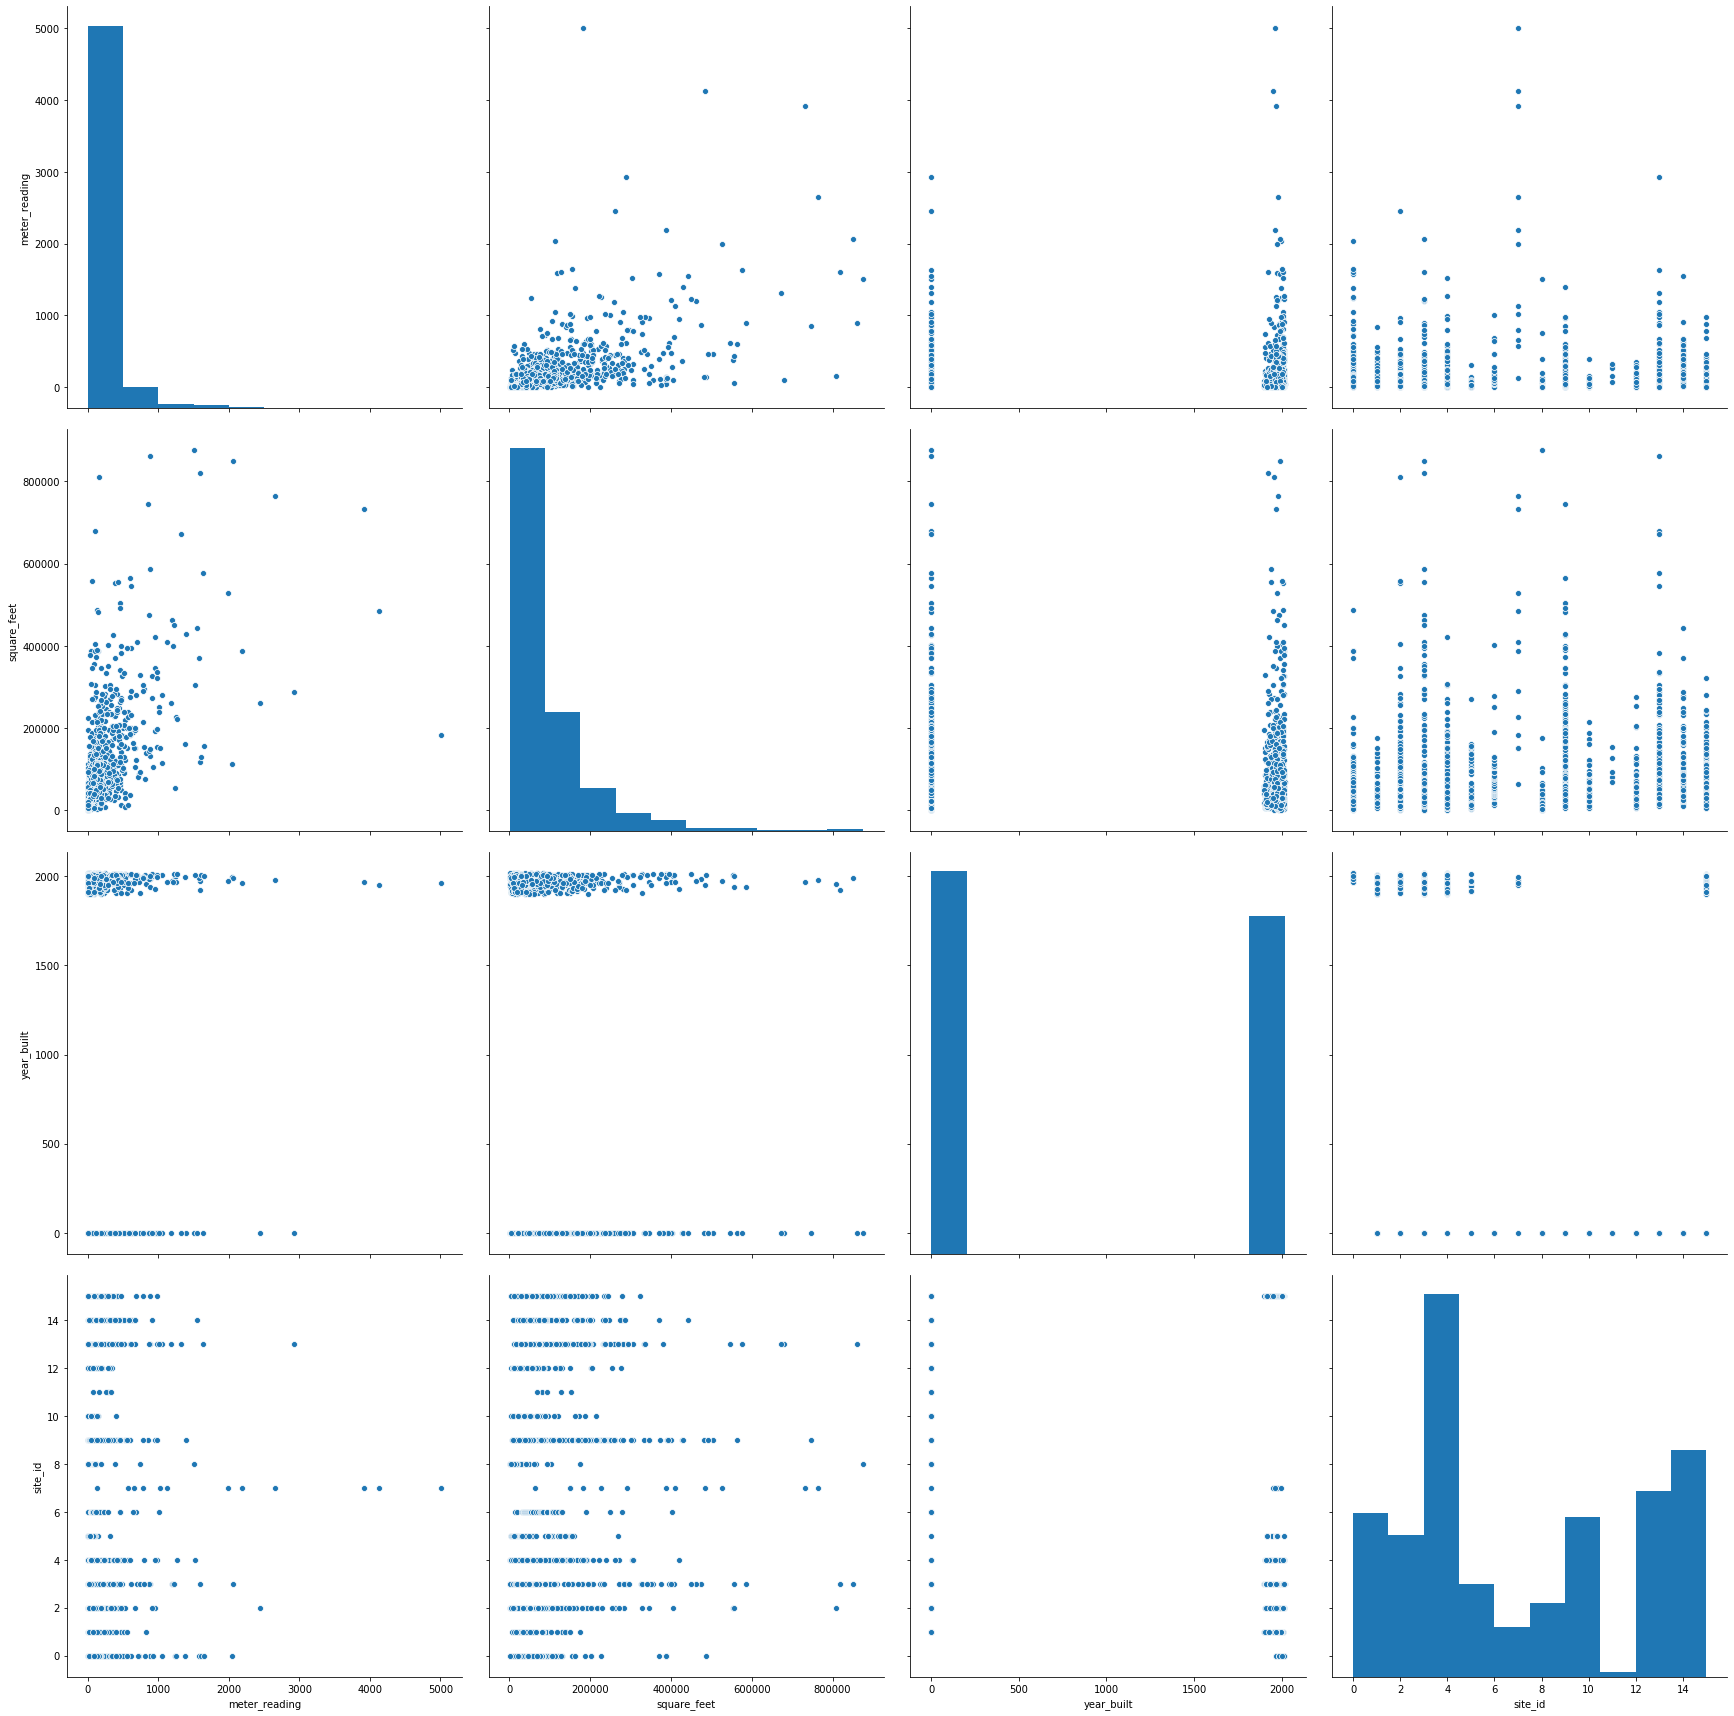

In [22]:
data_corr_meta = pd.DataFrame(energy.groupby("building_id").median(),
        columns=["meter_reading", "square_feet", "year_built", "site_id"])
data_corr_meta.dropna(inplace=True)
sns.pairplot(data_corr_meta, height=6)
plt.show()
del data_corr_meta

### Поиск зависимостей: погода

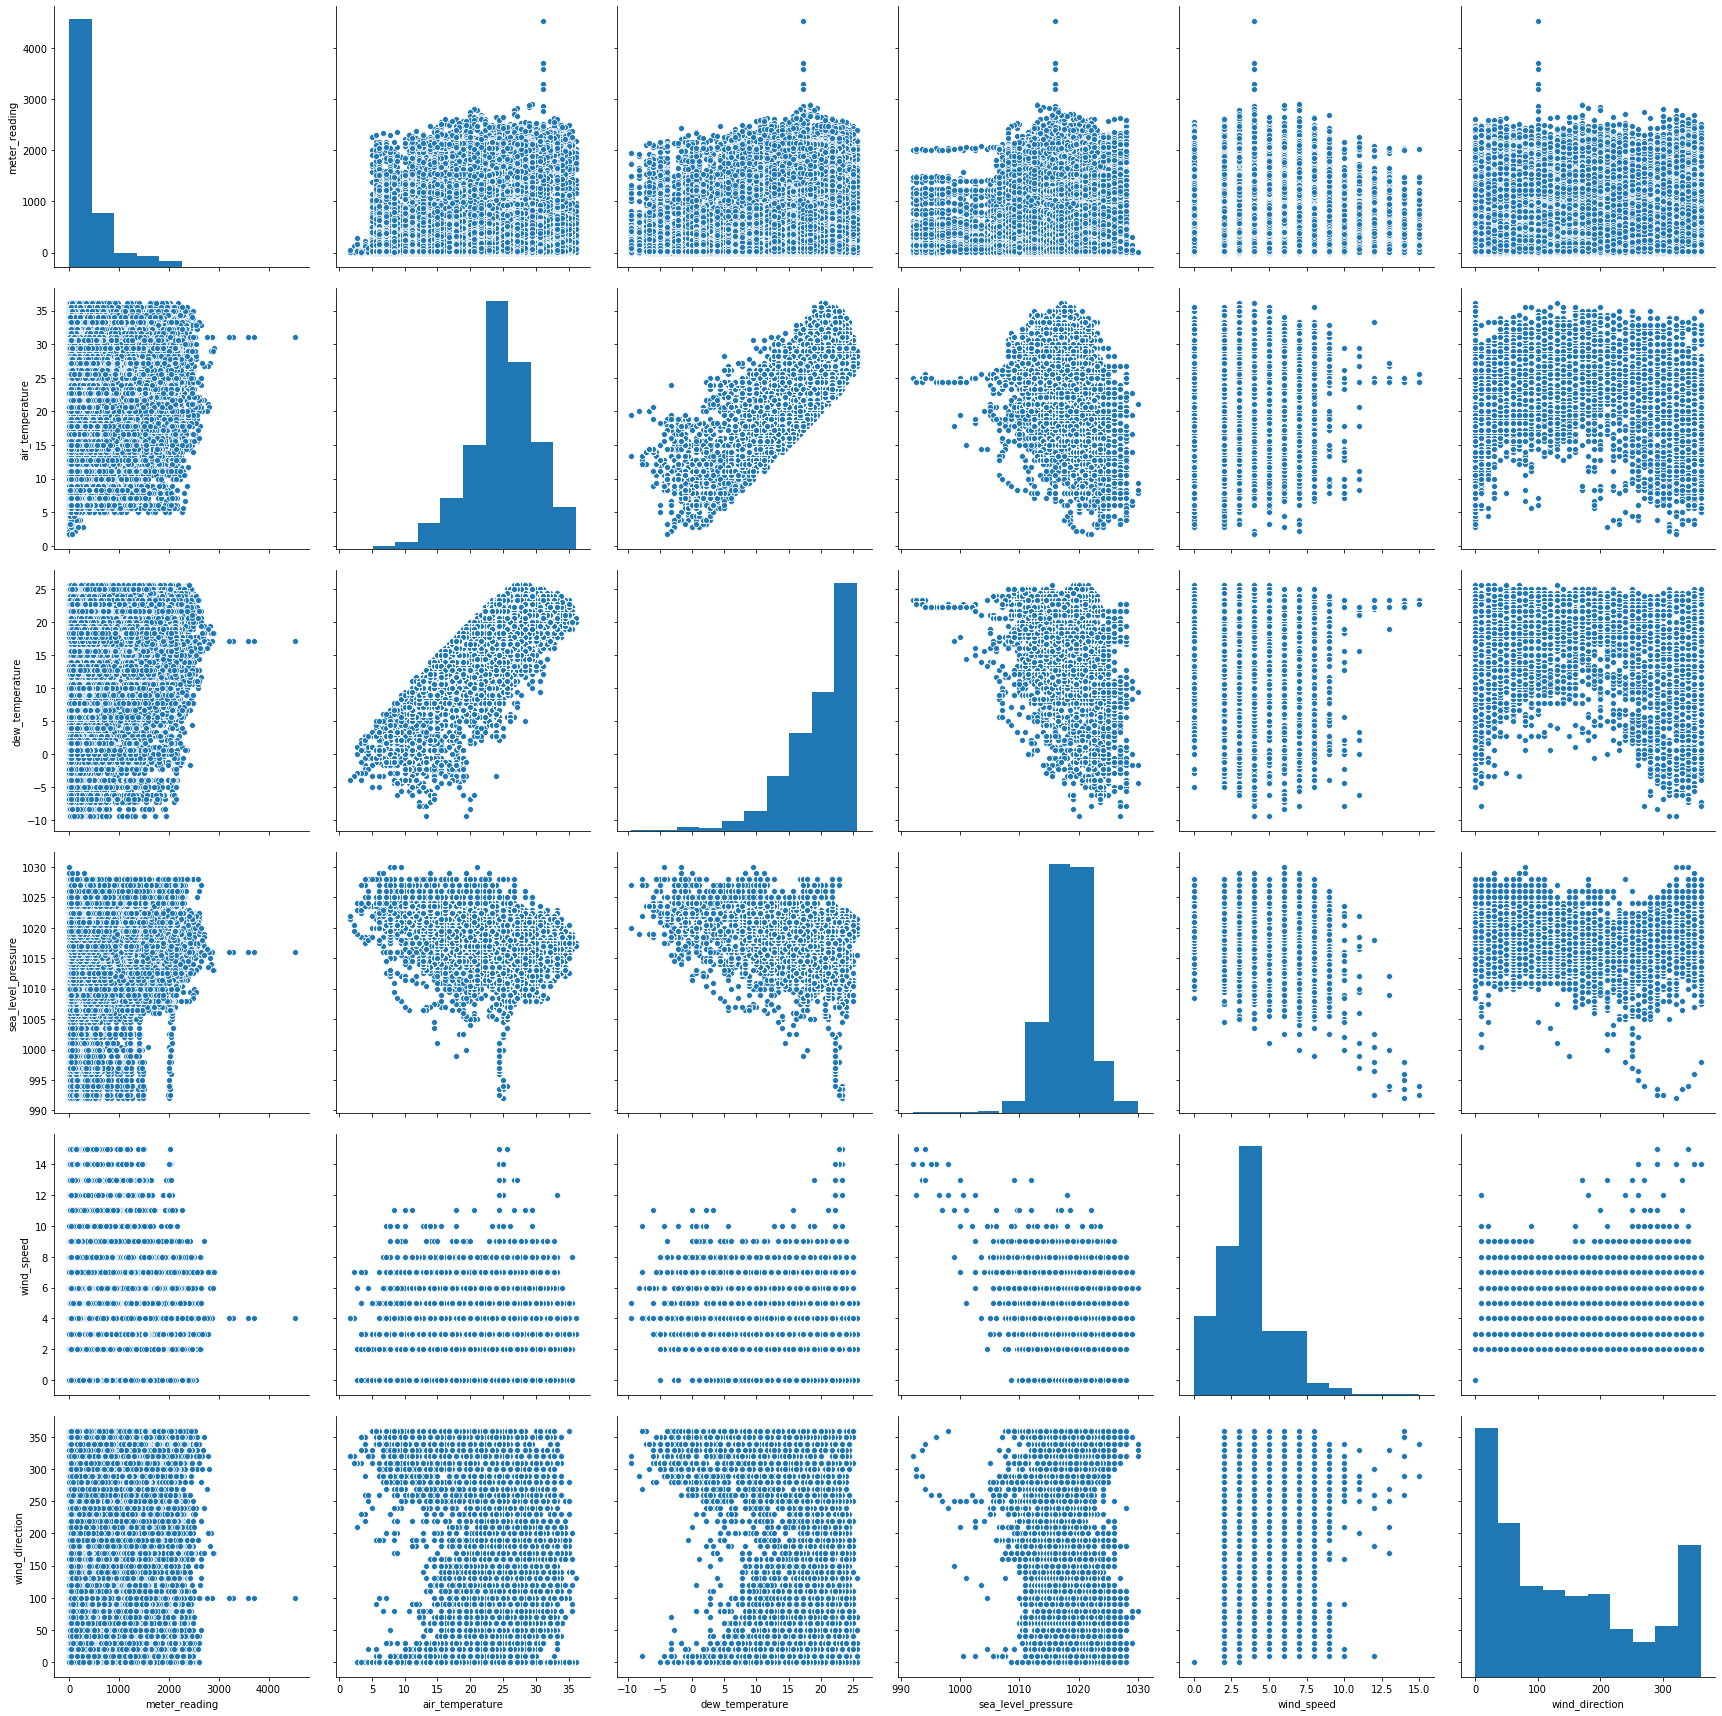

In [7]:
data_corr_weather = pd.DataFrame(energy[energy["site_id"] == 0],
    columns=["meter_reading", "air_temperature", "dew_temperature", "sea_level_pressure","wind_speed","wind_direction"])
data_corr_weather.dropna(inplace=True)
sns.pairplot(data_corr_weather, height=4)
plt.show()
del data_corr_weather

### Поиск зависимостей: тип здания

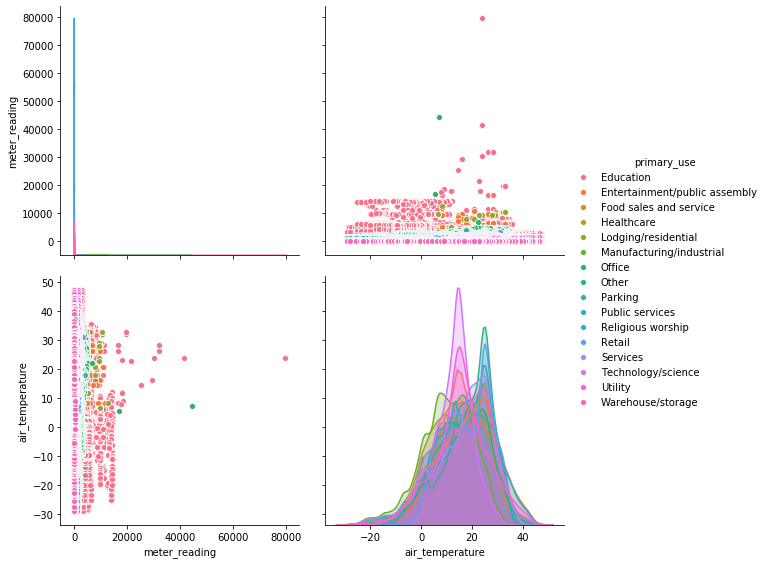

In [8]:
data_corr_temp_primary = pd.DataFrame(energy,
    columns=["meter_reading", "air_temperature", "primary_use"])
data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary, hue="primary_use", height=4)
plt.show()
del data_corr_temp_primary

### Поиск зависимостей: время

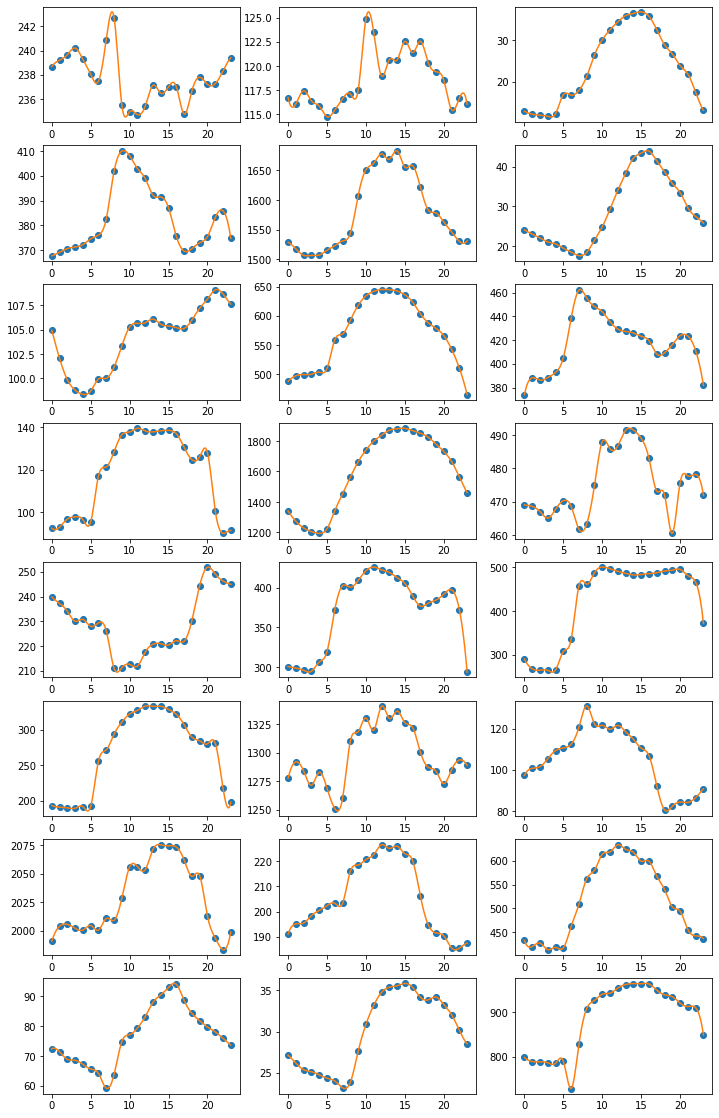

In [12]:
energy["hour"] = energy["timestamp"].dt.hour.astype("int8")
fig = plt.figure(figsize=(12,20))
for i in range(0, 24):
    fig.add_subplot(8, 3, i+1)
    train_df_i = energy[(energy["building_id"]==i) & (energy["meter_reading"]>0)]
    train_df_i_hourly = train_df_i.groupby("hour").mean().reset_index()
    x = np.arange(0, 24)
    y = interp1d(x, train_df_i_hourly["meter_reading"], kind="cubic")
    xn = np.arange(0, 23.1, 0.1)
    yn = y(xn)
    plt.plot(np.arange(0, 24),
             train_df_i_hourly["meter_reading"], 'o', xn, yn, '-')
plt.show()

### Поиск зависимостей: дата

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2017-01-01')
us_holidays = calendar().holidays(start=dates_range.min(),
                                  end=dates_range.max())

energy["dayofweek"] = energy["timestamp"].dt.dayofweek.astype("int8")
energy["day"] = energy["timestamp"].dt.day.astype("int8")
energy["dayofyear"] = energy["timestamp"].dt.dayofyear.astype("int16")
energy["month"] = energy["timestamp"].dt.month.astype("int8")
energy["week"] = energy["timestamp"].dt.week.astype("int8")
energy["date"] = pd.to_datetime(energy["timestamp"].dt.date)
energy['is_holiday'] = (energy['date'].isin(us_holidays)).astype("int8")

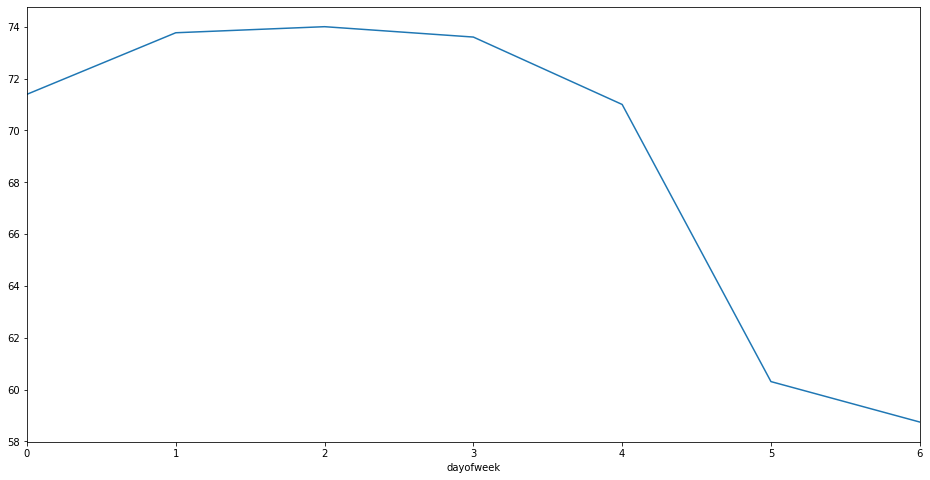

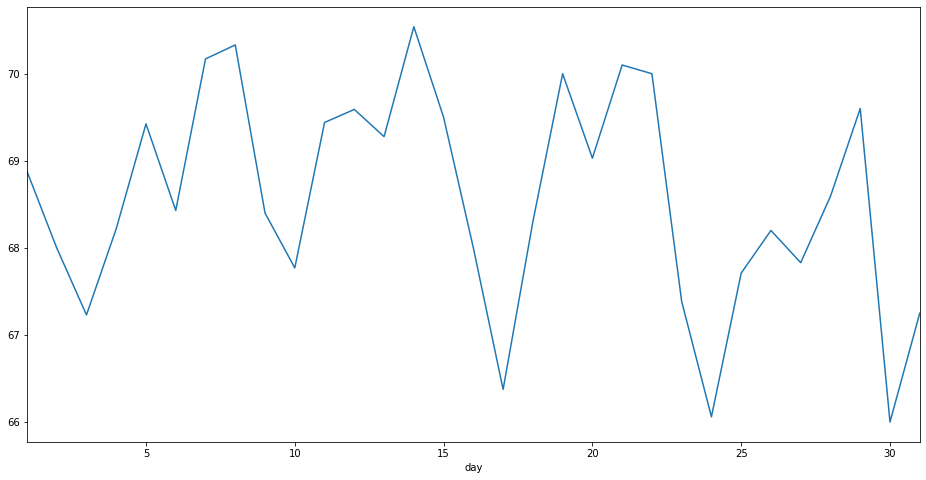

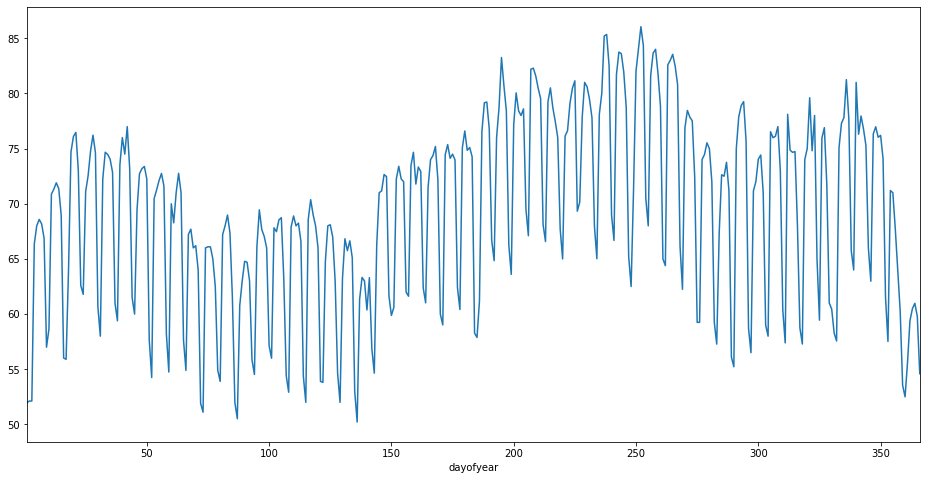

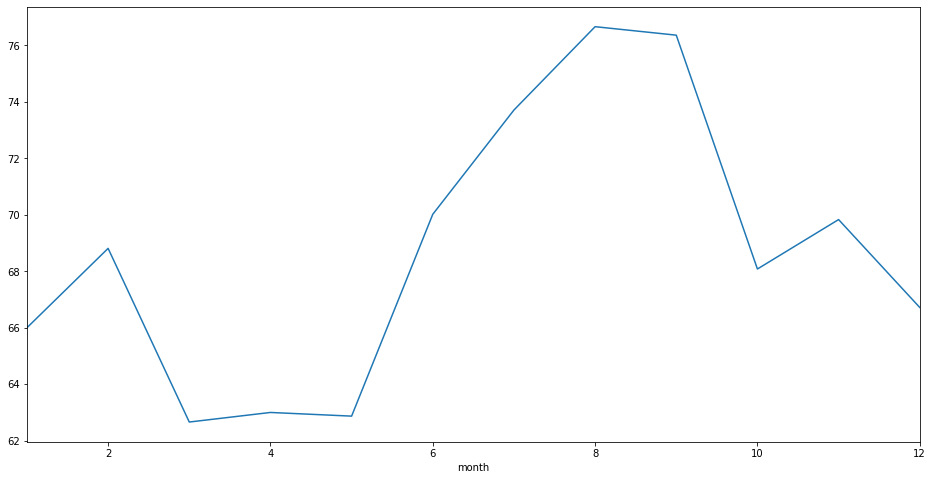

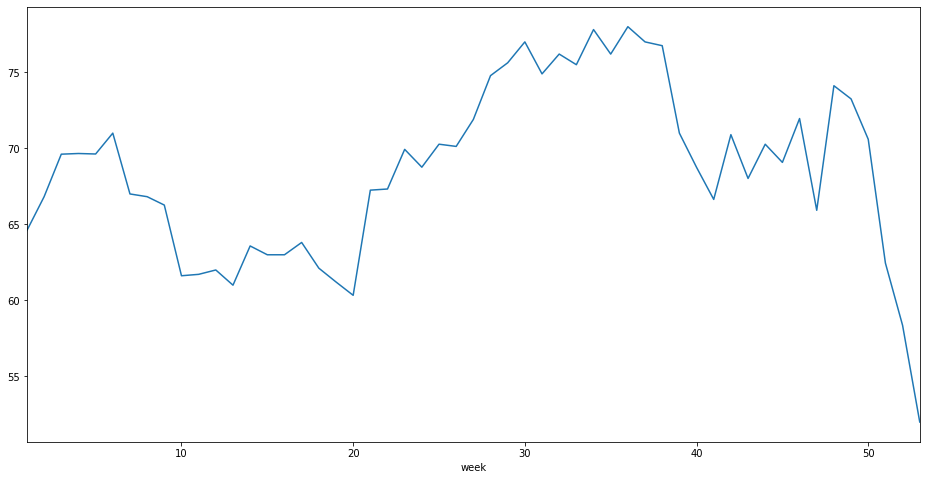

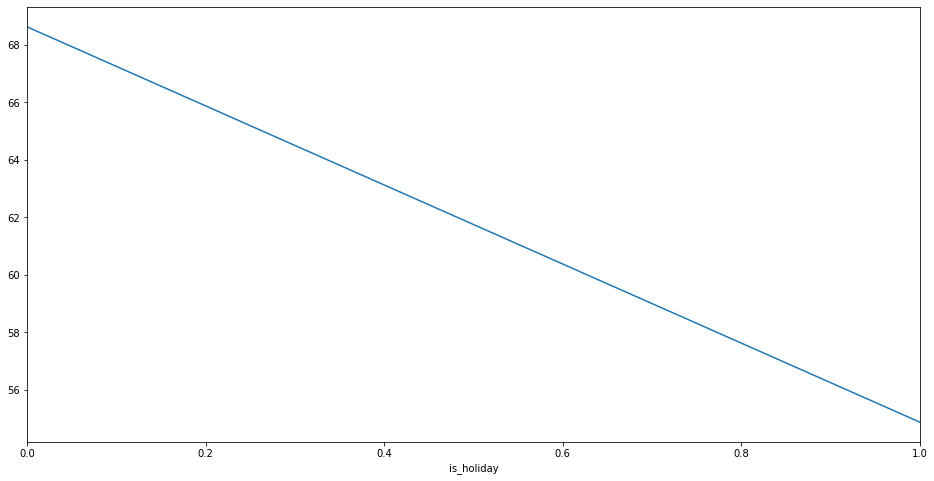

In [19]:
energy.groupby("dayofweek").median()["meter_reading"].plot()
plt.show()
energy.groupby("day").median()["meter_reading"].plot()
plt.show()
energy.groupby("dayofyear").median()["meter_reading"].plot()
plt.show()
energy.groupby("month").median()["meter_reading"].plot()
plt.show()
energy.groupby("week").median()["meter_reading"].plot()
plt.show()
energy.groupby("is_holiday").median()["meter_reading"].plot()
plt.show()

### Очистка памяти

In [ ]:
del energy